# Allocation of Demand based on Disaggregation and Re-aggregation of Data

This notebook is used to disaggregate demand from the FERC-714 dataset, based on the population from census data, then re-aggregating it to different various geometries like REEDs balancing areas, county-level, or at the state level.

## Datasets and inputs used

1. FERC-714 form: Energy sales timeseries data for every planning area

2. 2010 US Census data: Census tract geometries, and tract-level population and characteristics

3. ReEDs balancing geometries: ReEDs geometries containing county level data

4. US Planning Areas: Contains 97 planning area geometries

## Core functions

1. Function to find intersection of the large and small geometries

2. Function to normalize and redistribute from area to another attribute e.g. population

3. Map functions:

4. Timeseries functions: Functions for allocation

## Disposable parts of analysis

1. Cells doing auxiliary analysis like multiple-counted areas, visualizations for state, county and census tracts 

## Intermediate and Final Datasets

Intermediate datasets are required to limit the number of time-consuming calculations. Primarily, the overlay calculation takes excessive time.

### Intermediate Datasets

Area mapping of planning area with census tracts.

### Final Datasets

ReEDs aggregated demand timeseries data

## Workflow

1. There are generally two geometries: one containing primary smaller non-intersecting geometries like tracts, and the other with larger intersecting geometries

### Disaggregation of data

1. 

### Reaggregation of data

1. 


In [7]:
import sys
import os
import pathlib
import time
import requests
import json
import datetime
import pickle

import pandas as pd
import numpy as np
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
import seaborn as sns

import pyproj
from geopandas import gpd
from shapely.geometry import Point
import geopandas
import fiona
from geopandas import GeoDataFrame

import pudl
from pudl.extract.ferc714 import extract
from pudl.transform.ferc714 import transform
from pudl.analysis.demand_mapping import (create_intersection_matrix,
                                          create_stacked_intersection_df,
                                          extract_multiple_tracts_demand_ratios,
                                          extract_time_series_demand_multiple_tracts,
                                          matrix_linear_scaling)

from tqdm import tqdm
tqdm.pandas()

/home/yashkumar/anaconda3/envs/pudl-dev/lib/python3.8/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
pudl_path = "~/Desktop/work/github-repos-and-projects/pudl-ferc714/pudl"
pudl_settings = pudl.workspace.setup.derive_paths(pudl_in=pudl_path, pudl_out=pudl_path)
data_path = pathlib.Path.cwd().parent / 'data'

In [5]:
def download_zip_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

try:
    ferc714_url = "https://www.ferc.gov/docs-filing/forms/form-714/data/form714-database.zip"
    path_ferc714 = pathlib.Path(pudl_settings["data_dir"]) / "local/ferc714/data"
    os.makedirs(path_ferc714)
    
except:
    pass

try:
    download_zip_url(ferc714_url, str(path_ferc714 / "ferc714.zip"))
    
except:
    pass

## Importing US Census Data

In [10]:
## Importing US census tract data: https://www.arcgis.com/home/item.html?id=ca1316dba1b442d99cb76bc2436b9fdb
path_census = str(data_path / "USA_Census_Tract_Boundaries/v10/tracts.gdb")
gdf = gpd.read_file(path_census, driver='FileGDB', layer='tracts')

gdf["STATE_FIPS"] = pd.to_numeric(gdf["STATE_FIPS"])

## Removing all islands and non-mainland states and territories
gdf = gdf[(gdf["STATE_FIPS"] <= 56) &
          (gdf["STATE_FIPS"] != 44) &
          (gdf["STATE_FIPS"] != 15) &
          (gdf["STATE_FIPS"] != 2)]

## Projecting to US Albers conic equal-area projection
gdf = gdf.to_crs("ESRI:102003")
gdf.head()

## Importing US Planning Area Shapefiles & Demand Time Series

In [77]:
## Importing US planning areas: https://hifld-geoplatform.opendata.arcgis.com/datasets/electric-planning-areas
path_dhs_pa_shp = str(data_path / "DHS/Electric_Planning_Areas.gdb")
gdf_planning_areas = gpd.read_file(path_dhs_pa_shp, driver='FileGDB', layer='Planning_Areas')

## Dropping islands and non-mainland states and territories
gdf_planning_areas = gdf_planning_areas.drop([92, 68])
gdf_planning_areas["ID"] = pd.to_numeric(gdf_planning_areas["ID"])

## Projecting to US Albers conic equal-area projection
gdf_planning_areas = gdf_planning_areas.to_crs("ESRI:102003")
## IDs different for the areas, needed to be renamed
gdf_planning_areas.loc[gdf_planning_areas["ID"]==2775, "ID"] = 229
gdf_planning_areas.loc[gdf_planning_areas["ID"]==59504, "ID"] = 17690
gdf_planning_areas.loc[gdf_planning_areas["ID"]==14379, "ID"] = 14354
gdf_planning_areas.loc[gdf_planning_areas["ID"]==13670, "ID"] = 39347

## Importing demand timeseries data
dict_ferc714 = extract(pudl_settings=pudl_settings)
dict_ferc714 = transform(dict_ferc714)
ferc_df = dict_ferc714["pa_demand_hourly_ferc714"].merge(dict_ferc714["respondent_id_ferc714"])


## merging 2018 demand data with gdf_planning_areas
ferc_demand_sum = (ferc_df[(ferc_df["utc_datetime"]>="2018-01-01") &
                           (ferc_df["utc_datetime"]<"2019-01-01")]
                   .groupby("utility_id_eia")[["demand_mwh"]]
                   .sum()
                   .reset_index())

ferc_demand_sum = ferc_demand_sum.rename(columns={"demand_mwh": "demand_mwh_2018"})

pd.set_option("max_rows", 200)

display(gdf_planning_areas[["ID", "NAME"]]
 .drop_duplicates()
 .merge(ferc_df[["utility_name_ferc714", "utility_id_eia"]][(ferc_df["utc_datetime"]>="2018-01-01") &
                           (ferc_df["utc_datetime"]<"2019-01-01")]
        .drop_duplicates(), how="outer", left_on="ID", right_on="utility_id_eia"))

pd.reset_option("max_rows")

gdf_planning_areas = (gdf_planning_areas
                      .merge(ferc_demand_sum, how="inner", left_on="ID", right_on="utility_id_eia")
                      .drop("utility_id_eia", axis=1))

In [94]:
## Areas in demand dataframe that do not have a shape geometry

(ferc_demand_sum[~ferc_demand_sum["utility_id_eia"].isin(pop_norm_matrix.columns)]
 .merge(ferc_df[["utility_id_eia", "utility_name_ferc714"]])
 .drop_duplicates())

,utility_id_eia,demand_mwh_2018,utility_name_ferc714
0,3522,1258721.00,"Chugach Electric Association, Inc."
113952,13100,11134954.00,Municipal Electric Authority of Georgia
157776,13670,3367505.00,Northeast Texas Electric Cooperative
271728,17867,807567.00,City of St. Cloud
385680,19547,7001225.93,"Hawaiian Electric Company, Inc"


## Finding intersection area of each census tract with each planning area for demand allocation 

In [80]:
file_save = "tracts_planning_area_ratios_stacked.pkl"

if sum([file_save in str(a) for a in data_path.glob("*")]):

    with open(str(data_path / file_save), "rb") as f:
        gdf_intersection = pickle.load(f)
    
else:
    start_time = time.time()
    gdf_intersection = create_stacked_intersection_df(gdf, gdf_planning_areas, file_save_name=file_save)
    print("--- %s seconds ---" % (time.time() - start_time))
    with open(str(data_path / file_save), "wb") as f:
        pickle.dump(gdf_intersection, f)

## Pivoting the mapping to a matrix, and scaling/normalization by individual population, then finding allocating demand accordingly

In [84]:
intersection_matrix = create_intersection_matrix(gdf_intersection)
pop_norm_matrix = matrix_linear_scaling(intersection_matrix, gdf_scale=gdf)
demand_norm_matrix = matrix_linear_scaling(pop_norm_matrix, gdf_scale=gdf_planning_areas,
                                          gdf_scale_col="demand_mwh_2018", axis_scale=0)

## Grouping demand data at the county and state level

In [85]:
gdf = gdf.merge(demand_norm_matrix
          .sum(axis=1)
          .reset_index()
          .rename(columns={0: "demand_mwh_2018"}))

## Created tracts demand aggregated by state
county_gdf = gdf[["STCOFIPS", "geometry"]].merge(gdf
                                                 .groupby("STCOFIPS")[["demand_mwh_2018", "SQMI", "POPULATION"]]
                                                 .sum()
                                                 .reset_index())

county_gdf["energy_demand_per_sqmi"] = county_gdf["demand_mwh_2018"] / county_gdf["SQMI"]
county_gdf["demand_per_capita"] = county_gdf["demand_mwh_2018"] / county_gdf["POPULATION"]

## Created tracts demand aggregated by state
state_gdf = gdf[["STATE_FIPS", "geometry"]].merge(gdf
                                                  .groupby("STATE_FIPS")[["demand_mwh_2018", "SQMI", "POPULATION"]]
                                                  .sum()
                                                  .reset_index())

state_gdf["energy_demand_per_sqmi"] = state_gdf["demand_mwh_2018"] / state_gdf["SQMI"]

state_gdf["demand_per_capita"] = state_gdf["demand_mwh_2018"] / state_gdf["POPULATION"]

## Incorporating state annual sales for residential, industrial comparison

In [93]:
sales_df = pd.read_excel(str(data_path / "EIA/sales_annual.xlsx"), skiprows=[0])
sales_df = sales_df[sales_df["Year"]==2018]
sales_df = sales_df[~sales_df["State"].isin(["US", "HI", "AK", "DC"])]
# print(sales_df["Industry Sector Category"].unique())
sales_df = sales_df[sales_df["Industry Sector Category"]=="Total Electric Industry"]

states_fips_lookup = pd.read_html("https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696")[0].iloc[:-1]
states_fips_lookup = states_fips_lookup.astype({
    "FIPS": "int32"
})

# states_fips_lookup["FIPS"] = states_fips_lookup["FIPS"].apply(lambda x: int(x))

sales_df = sales_df.merge(states_fips_lookup, left_on="State",
                          right_on="Postal Code")[["State", "Total", "FIPS",
                                                   "Residential", "Commercial", "Industrial"]]

sales_df = (state_gdf[["STATE_FIPS", "demand_mwh_2018"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .merge(sales_df, left_on="STATE_FIPS", right_on="FIPS")).drop("FIPS", axis=1)

sales_df = sales_df.sort_values("demand_mwh_2018", ascending=False).reset_index(drop=True)

sales_df["pc_error"] = abs(sales_df["Total"] - sales_df["demand_mwh_2018"]) / sales_df["Total"]


sales_df = sales_df.sort_values("pc_error", ascending=False).reset_index(drop=True)
sales_sum = sales_df["Total"].sum()
allocated_demand_sum = sales_df["demand_mwh_2018"].sum()

sales_df["adjusted_demand"] = sales_df["demand_mwh_2018"] * sales_sum / allocated_demand_sum

sales_df.head()

,STATE_FIPS,demand_mwh_2018,State,Total,Residential,Commercial,Industrial,pc_error,adjusted_demand
0,31,5.443357e+07,NE,30939492,10412008,9553396,10974088,0.759356,4.896056e+07
1,46,2.134796e+07,SD,12856938,5018360,4903243,2935335,0.660423,1.920153e+07
2,20,6.638915e+07,KS,42036979,14187192,16168750,11681037,0.579304,5.971407e+07
3,30,2.266331e+07,MT,14838845,5197686,4921231,4719928,0.527296,2.038464e+07
4,34,1.153451e+08,NJ,76016762,29530689,38807065,7369106,0.517364,1.037477e+08


## Allocating demand time series at the state level

In [101]:
df_state_sales = []
dict_state_tracts = gdf.groupby("STATE_FIPS").agg({"FIPS": list}).to_dict()["FIPS"]
dict_statefips_names = states_fips_lookup.set_index("FIPS")["Name"].to_dict()
dict_statefips_names[11] = "DC"

for state_tracts in tqdm(dict_state_tracts.values()):
    
    ser = extract_time_series_demand_multiple_tracts(ferc_df, pop_norm_matrix, "utility_id_eia", state_tracts,
                                                    time_col="utc_datetime", demand_col="demand_mwh")
    df_state_sales.append(ser)
    
df_state_sales = pd.concat(df_state_sales, axis=1, keys=[dict_statefips_names[key] + "_Sales"
                                                         for key in dict_state_tracts.keys()])

df_state_sales_monthly = df_state_sales.groupby(pd.Grouper(freq="M")).sum()


df_state_sales_2018 = df_state_sales_monthly[(df_state_sales_monthly.index >= "2018-01-01") &
                       (df_state_sales_monthly.index <= "2018-12-31")].stack().reset_index().rename(columns={"level_1": "State", 0: "GWh_allocated"})

df_state_sales_2018["GWh_allocated"] = df_state_sales_2018["GWh_allocated"] / 1000

df_state_sales_2018["utc_datetime"] = (df_state_sales_2018["utc_datetime"].dt.year * 100 +
                                     df_state_sales_2018["utc_datetime"].dt.month)

df_state_sales_2018["State"] = df_state_sales_2018["State"].str.rstrip('Sales').str.rstrip('_').str.strip()

100%|██████████| 48/48 [00:47<00:00,  1.00it/s]


## Extracting state sales from EIA

In [102]:
sales_data = (json.loads(requests
                         .get("http://api.eia.gov/category/?api_key=d2b250683a925a1bddcd63c5d12698c0&category_id=38")
                         .text))

sales_data_urls = [a["series_id"]
                   for a in sales_data["category"]["childseries"]
                   if a["series_id"][-1] == "M"]

sales_data_states_names = [a["name"][30:-23]
                           for a in sales_data["category"]["childseries"]
                           if a["series_id"][-1] == "M"]


df_sales_eia = []

for index in tqdm(range(len(sales_data_urls))):
    
   
    
    df_sales_eia.append(pd.DataFrame((json.loads(requests
            .get("http://api.eia.gov/series/?api_key=d2b250683a925a1bddcd63c5d12698c0&series_id=" +
                 sales_data_urls[index])
            .text))["series"][0]["data"])
                        .rename(columns={0: "utc_datetime", 1: sales_data_states_names[index]})
                        .set_index("utc_datetime"))
    
    
df_sales_eia = pd.concat(df_sales_eia, axis=1).reset_index()
df_sales_eia["utc_datetime"] = pd.to_numeric(df_sales_eia["utc_datetime"])


df_sales_eia_2018 = df_sales_eia[df_sales_eia["utc_datetime"] // 100 == 2018]
df_sales_eia_2018 = df_sales_eia_2018.set_index("utc_datetime").stack().reset_index().rename(columns={"level_1": "State", 0: "GWh"})
df_sales_eia_2018["State"] = df_sales_eia_2018["State"].str.strip()


## Scaling Demand Time Series by a constant factor to make the total sums equal
df_check = df_state_sales_2018.merge(df_sales_eia_2018, how="inner")

df_check["GWh_adjusted"] = df_check["GWh_allocated"] * df_check["GWh"].sum() / df_check["GWh_allocated"].sum()

100%|██████████| 62/62 [00:07<00:00,  7.90it/s]


## Extracting 2018 REEDS data

In [123]:
path_reeds = str(data_path / "NREL/us_canada_reeds_map_files")
gdf_reeds = gpd.read_file(path_reeds)
gdf_reeds["pca_num"] = pd.to_numeric(gdf_reeds["pca"].str.slice_replace(stop=1, repl=""))
gdf_reeds = gdf_reeds[gdf_reeds["pca_num"]<=134]
gdf_reeds = gdf_reeds.to_crs("ESRI:102003")

file_save = "tracts_reeds_areas_ratios_stacked.pkl"

if sum([file_save in str(a) for a in data_path.glob("*")]):

    with open(str(data_path / file_save), "rb") as f:
        gdf_reeds_intersection = pickle.load(f)
    
else:
    start_time = time.time()
    gdf_reeds_intersection = create_stacked_intersection_df(gdf, gdf_reeds, gdf_secondary_col="OBJECTID")
    pickle.dump(gdf_reeds_intersection, open(file_save, "wb" ))
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
reeds_intersection_matrix = create_intersection_matrix(gdf_reeds_intersection,
                                                       gdf_source_col="OBJECTID",
                                                       gdf_intersection_col='gdf_primary_intersection_fraction')

pop_norm_reeds = matrix_linear_scaling(reeds_intersection_matrix, gdf)

reeds_demand_2018 = matrix_linear_scaling(pop_norm_reeds,
                                          gdf_scale=gdf,
                                          gdf_scale_col="demand_mwh_2018",
                                          axis_scale=1)

gdf_reeds = gdf_reeds.set_index("OBJECTID")
gdf_reeds["demand_2018_mwh"] = reeds_demand_2018.sum(axis=0)
gdf_reeds = gdf_reeds.reset_index()

## Aggregating REEDS data at PCA level
reeds_pca = (gdf_reeds
             .drop("demand_2018_mwh", axis=1)
             .merge(gdf_reeds.groupby("pca_num")["demand_2018_mwh"].sum().reset_index()))

## Mapping from Census-Planning Areas & Census-REEDS to REEDS-Planning Areas

In [109]:
drop_fips = (set(pop_norm_reeds[pop_norm_reeds.sum(axis=1) == 0].index)
             .union(set(pop_norm_matrix[pop_norm_matrix.sum(axis=1) == 0].index)))

common_fips = (set(pop_norm_matrix.index)
               .intersection(set(pop_norm_reeds.index))
               .difference(drop_fips))

pop_ferc_reeds= (pop_norm_reeds
                 .loc[common_fips].T
                 .divide(pop_norm_reeds.loc[common_fips]
                         .sum(axis=1))) @ pop_norm_matrix.loc[common_fips]

## Mapping FERC714 demand time series to pca areas

In [111]:
df_reeds_sales = []
dict_reeds_tracts = gdf_reeds.groupby("pca").agg({"OBJECTID": list}).to_dict()["OBJECTID"]

for objectids in tqdm(dict_reeds_tracts.values()):
    
    ser = extract_time_series_demand_multiple_tracts(ferc_df, pop_ferc_reeds, ferc_df_col="utility_id_eia",
                                                     intermediate_ids=objectids, time_col="utc_datetime",
                                                     demand_col="demand_mwh")
    df_reeds_sales.append(ser)
    
df_reeds_sales = pd.concat(df_reeds_sales, axis=1, keys=dict_reeds_tracts.keys())
df_reeds_sales_monthly = df_reeds_sales.groupby(pd.Grouper(freq="M")).sum() 

100%|██████████| 134/134 [02:13<00:00,  1.00it/s]


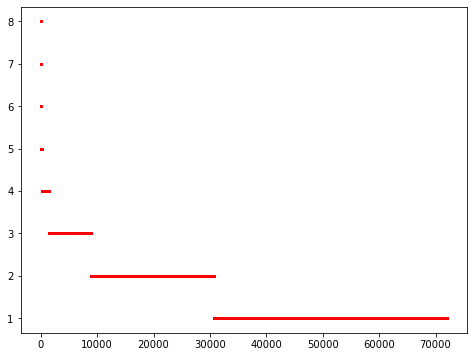

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot((intersection_matrix != 0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)

plt.show()

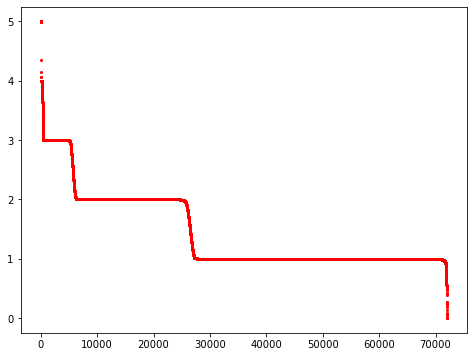

In [113]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(create_intersection_matrix(gdf_intersection, normalization=0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)

plt.show()

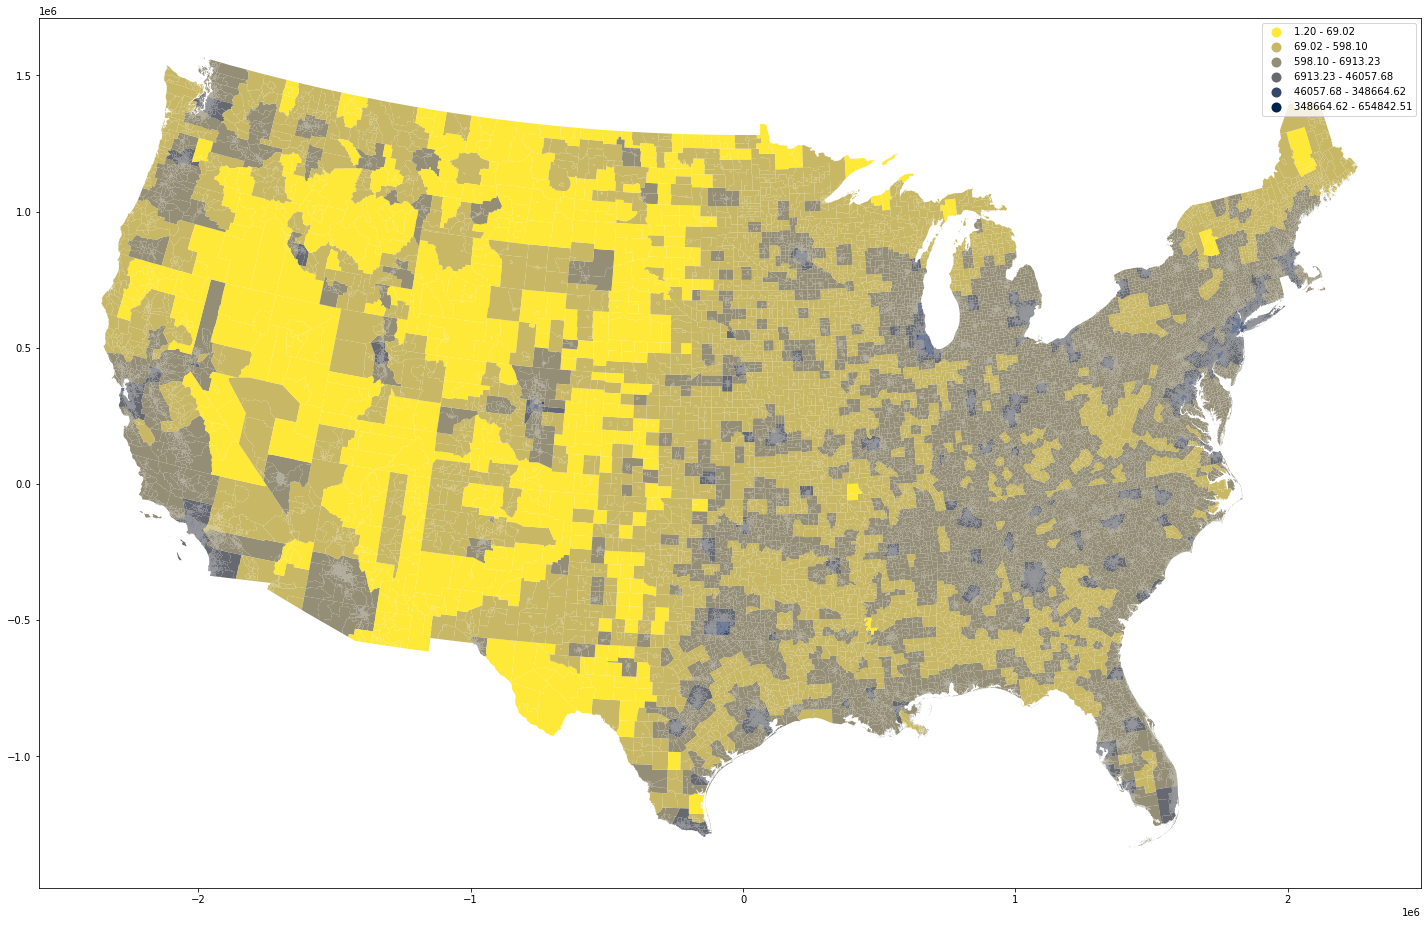

In [114]:
# County demand per unit area
fig, ax = plt.subplots(figsize=(28, 16))
county_gdf.plot(column="energy_demand_per_sqmi", cmap="cividis_r", ax=ax,
                          legend=True, scheme="percentiles")
plt.show()

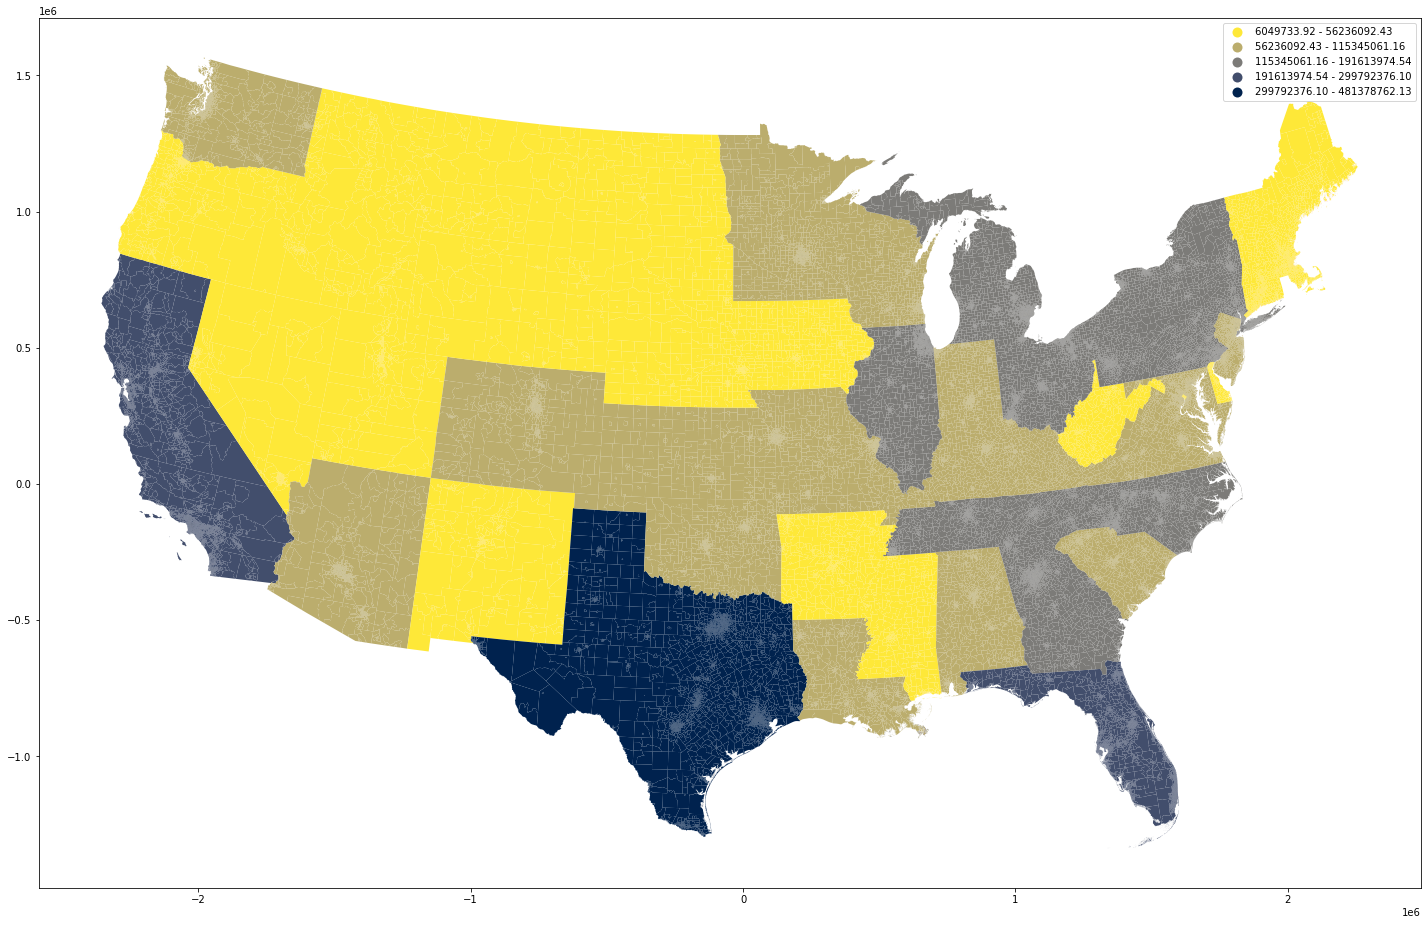

In [115]:
## State demand figure
fig, ax = plt.subplots(figsize=(28, 16))
state_gdf.plot(column="demand_mwh_2018", cmap="cividis_r", ax=ax, legend=True, scheme="NaturalBreaks")
plt.show()

In [18]:
# 6 figures of 8 states with allocated demand and FERC sales

# for i in range(6):

#     fig, ax = plt.subplots(figsize=(8, 6))

#     for idx, row in sales_df.iloc[8*i: 8*(i+1)].iterrows():

#         ax.plot([row["demand_mwh_2018"], row["Total"]], marker="o", label=row["State"])
        
#     plt.xticks([0, 1], ["Allocated Demand", "Sales"])
#     plt.legend()    
#     plt.show()
    

432978608.0301165

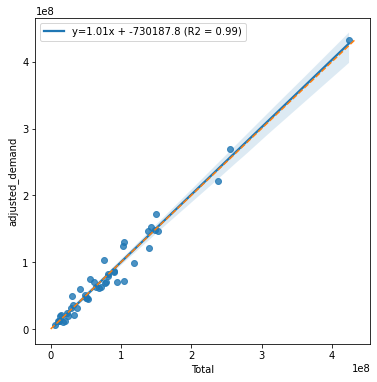

In [133]:
pred = 'adjusted_demand'
actual = "Total"


fig, ax = plt.subplots(figsize=(6, 6))

def r2(x, y):
    
    return scipy.stats.pearsonr(sales_df[actual], sales_df[pred])


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sales_df[actual], sales_df[pred])

sns.regplot(x=actual, y=pred, data=sales_df, ax = ax,
            line_kws={'label':"y={0:.2f}x + {1:.1f} (R2 = {2:.2f})".format(slope,intercept,r_value)})


min_lim, max_lim = 0, sales_df[[actual, pred]].max().max()


ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")

# ax = sns.jointplot(x="Residential", y="Demand", data=sales_df, stats_func=r2)


ax.legend()
plt.show()

## Comparison with monthly data using EIA 



In [103]:
# data_eia_states = (json
#                    .loads(requests
#                           .get("http://api.eia.gov/category/?api_key=d2b250683a925a1bddcd63c5d12698c0&category_id=40213")
#                           .text))




In [117]:
df_check["GWh_allocated"].sum() / df_check["GWh"].sum()

1.1117841694609543

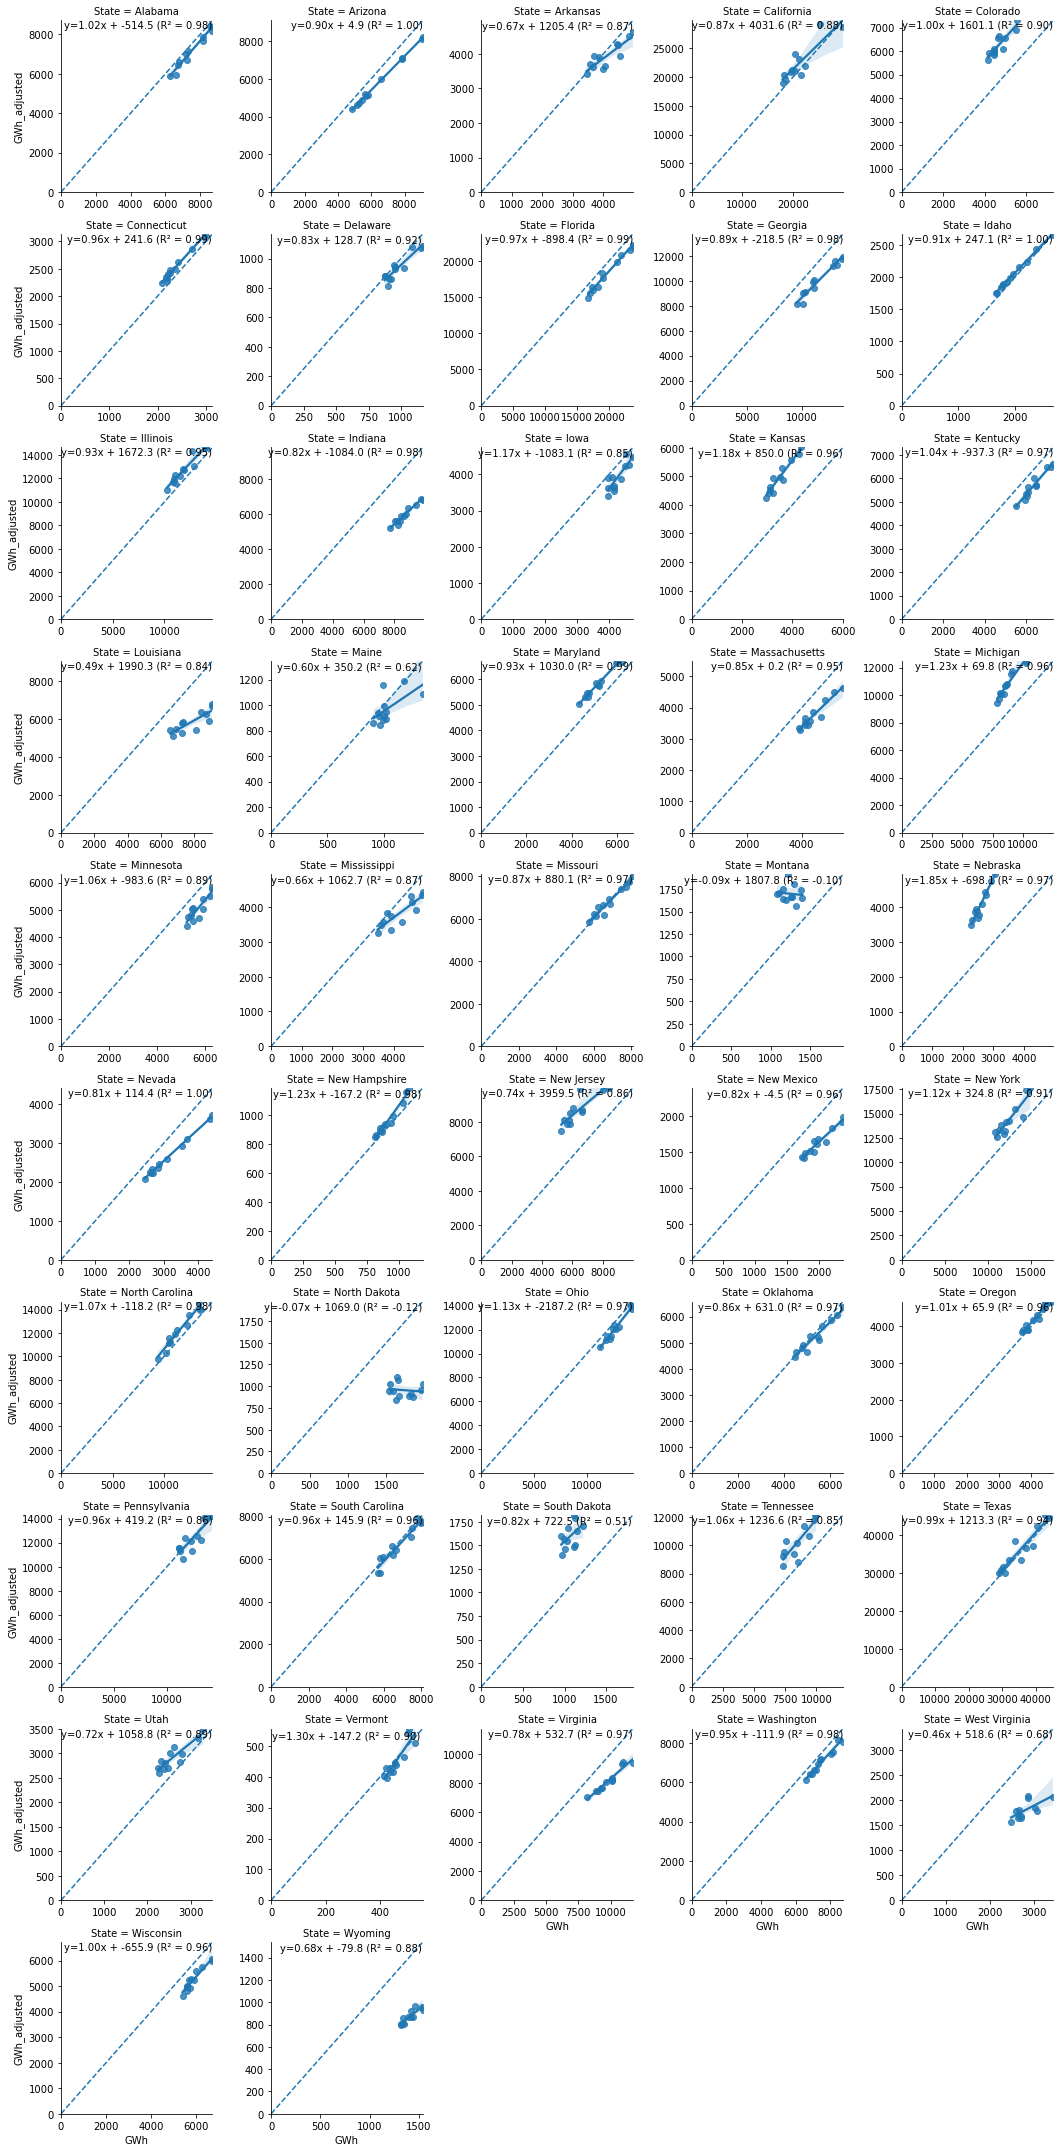

In [118]:
pred = 'GWh_adjusted'
actual = "GWh"


g = sns.FacetGrid(df_check, col="State", col_wrap=5, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

state_list = df_check["State"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["State"]==state_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

In [139]:
state_demand_factors = df_check.groupby("State").mean()
state_demand_factors["factor"] = state_demand_factors["GWh"] / state_demand_factors["GWh_adjusted"]
state_demand_factors = state_demand_factors["factor"].to_dict()
state_demand_factors

df_check["state_GWh_adjusted"] = df_check.apply(lambda x: x["GWh_adjusted"] * state_demand_factors[x["State"]],
                                                axis=1)
df_check

,utc_datetime,State,GWh_allocated,GWh,GWh_adjusted,state_GWh_adjusted
0,201801,Alabama,9387.393544,8571.05263,8443.539494,8843.217664
1,201801,Arizona,5444.045284,5461.68315,4896.674583,5442.887440
2,201801,Arkansas,4741.901714,4485.75249,4265.127931,4457.701508
3,201801,California,23431.970549,20455.04950,21076.006650,19948.498030
4,201801,Colorado,7288.799183,4646.72861,6555.947983,4909.067238
...,...,...,...,...,...,...
559,201812,Virginia,9245.601475,10083.55830,8316.003887,10008.812844
560,201812,Washington,9052.534091,8426.91923,8142.348434,8667.826903
561,201812,West Virginia,2039.916726,3024.45784,1834.813611,2850.710953
562,201812,Wisconsin,5821.228247,5910.84746,5235.933743,5861.858040


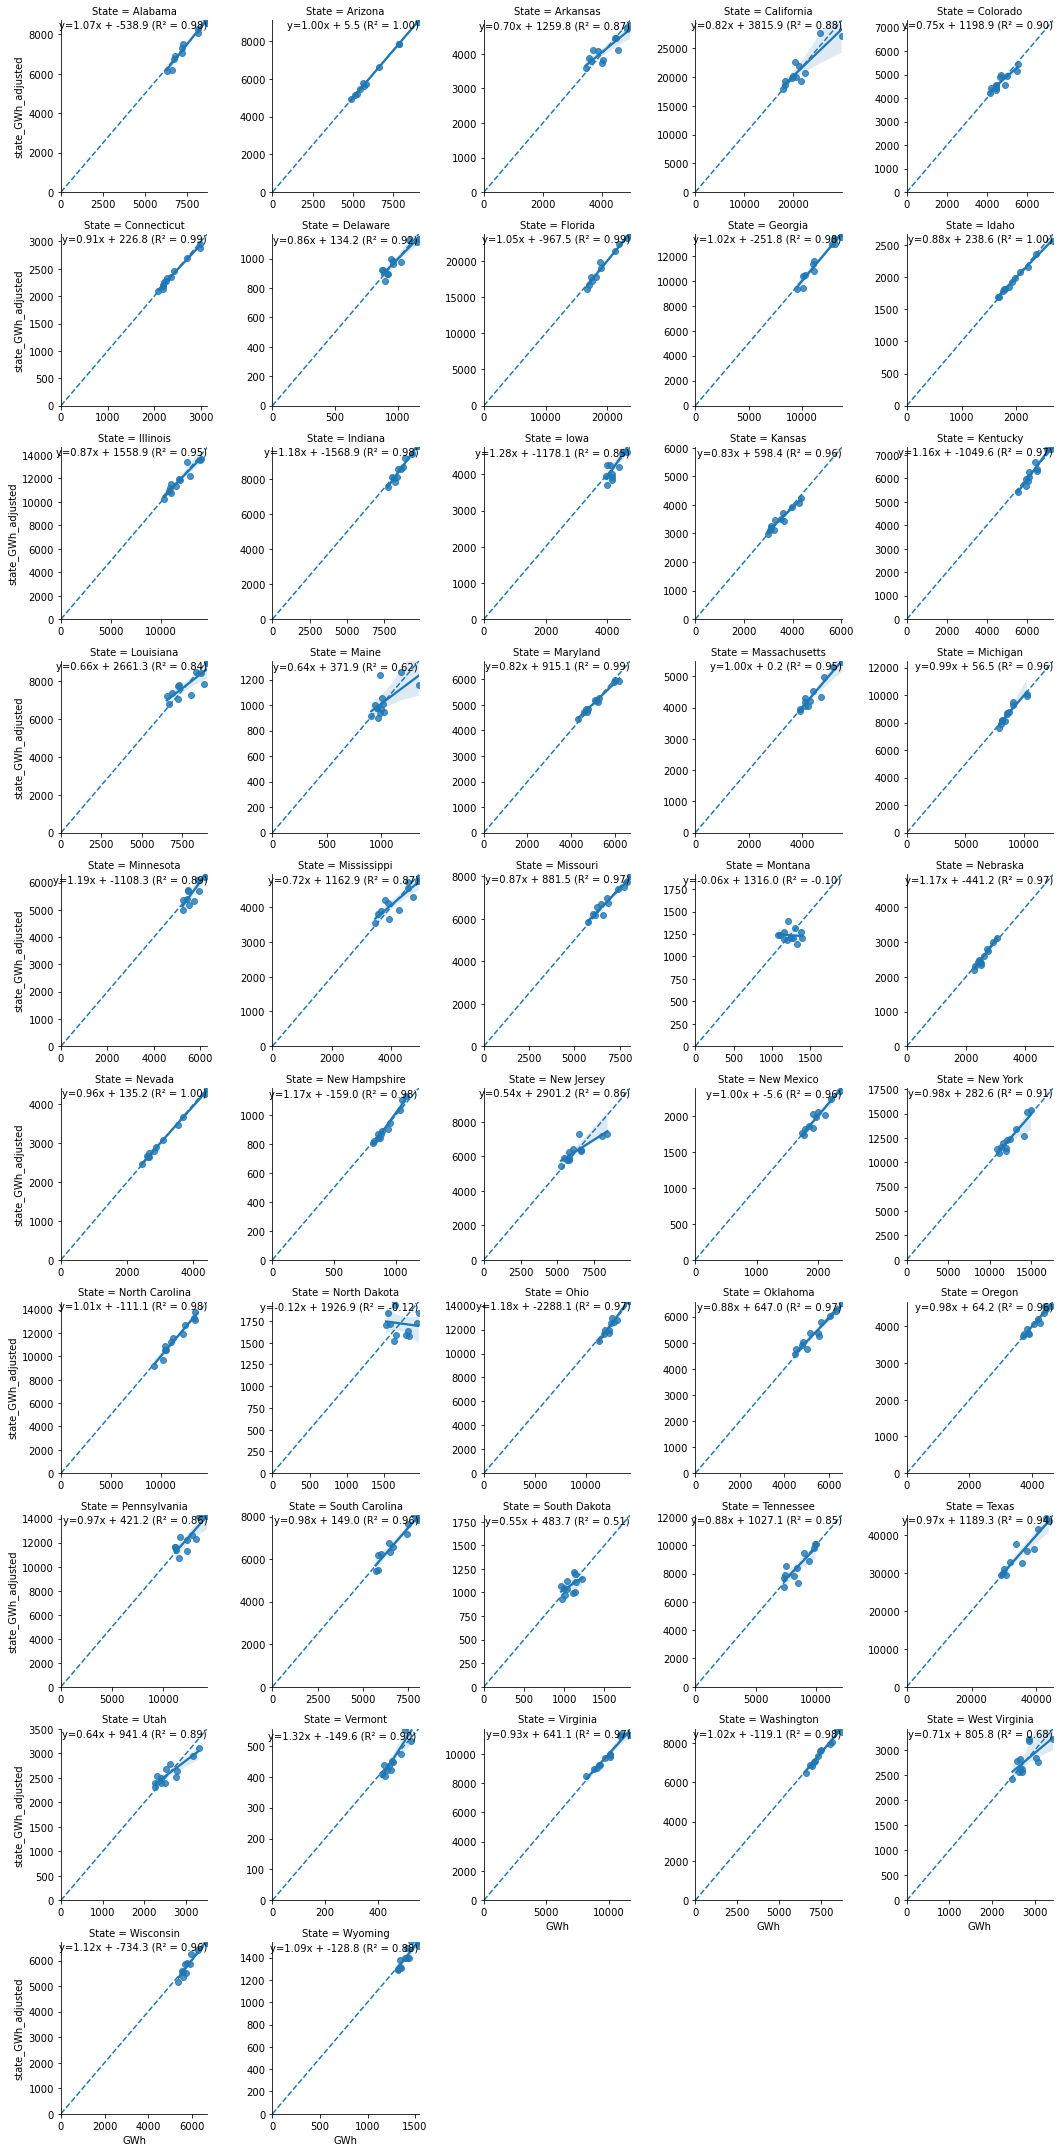

In [140]:
pred = 'state_GWh_adjusted'
actual = "GWh"


g = sns.FacetGrid(df_check, col="State", col_wrap=5, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

state_list = df_check["State"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["State"]==state_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

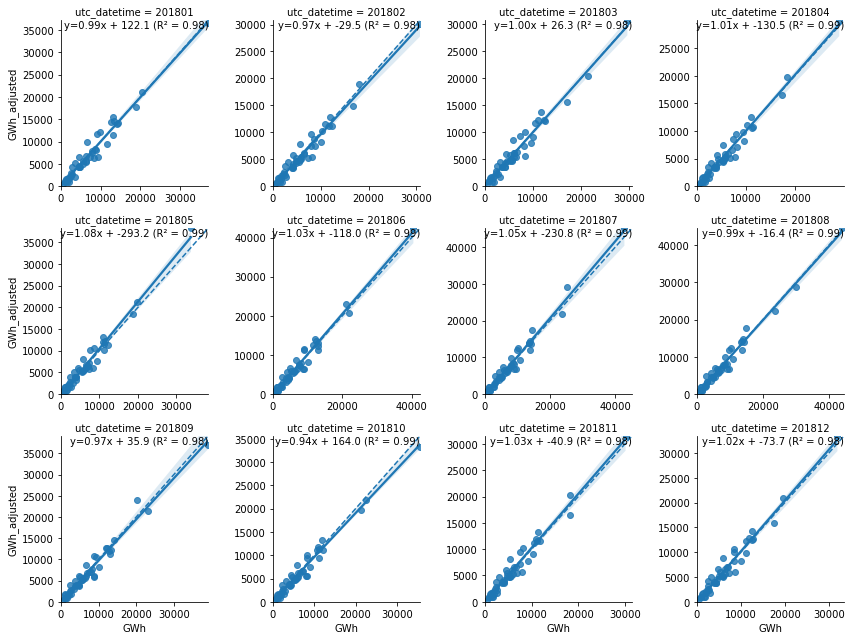

In [142]:
pred = 'GWh_adjusted'
actual = "GWh"

g = sns.FacetGrid(df_check, col="utc_datetime", col_wrap=4, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

time_list = df_check["utc_datetime"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["utc_datetime"]==time_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
      
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

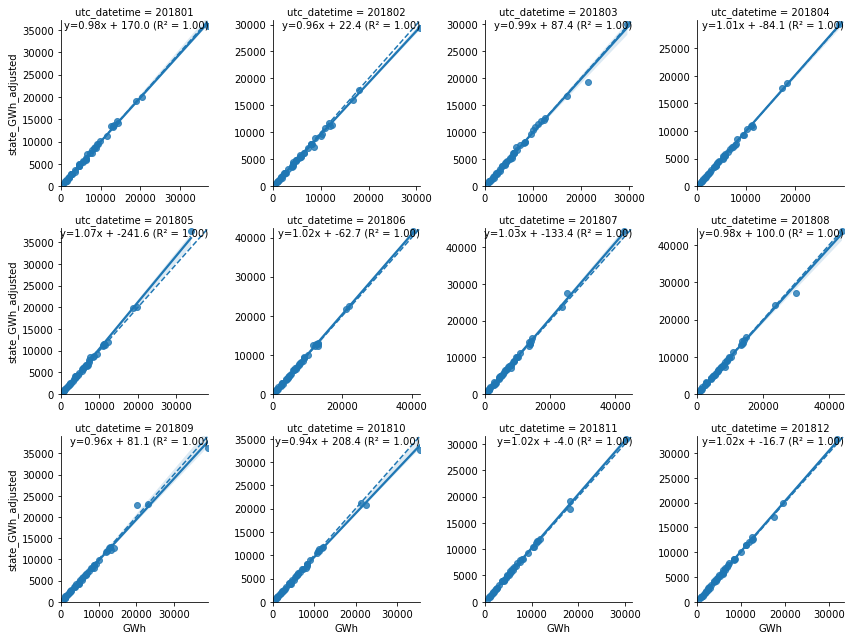

In [141]:
pred = 'state_GWh_adjusted'
actual = "GWh"

g = sns.FacetGrid(df_check, col="utc_datetime", col_wrap=4, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

time_list = df_check["utc_datetime"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["utc_datetime"]==time_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
      
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

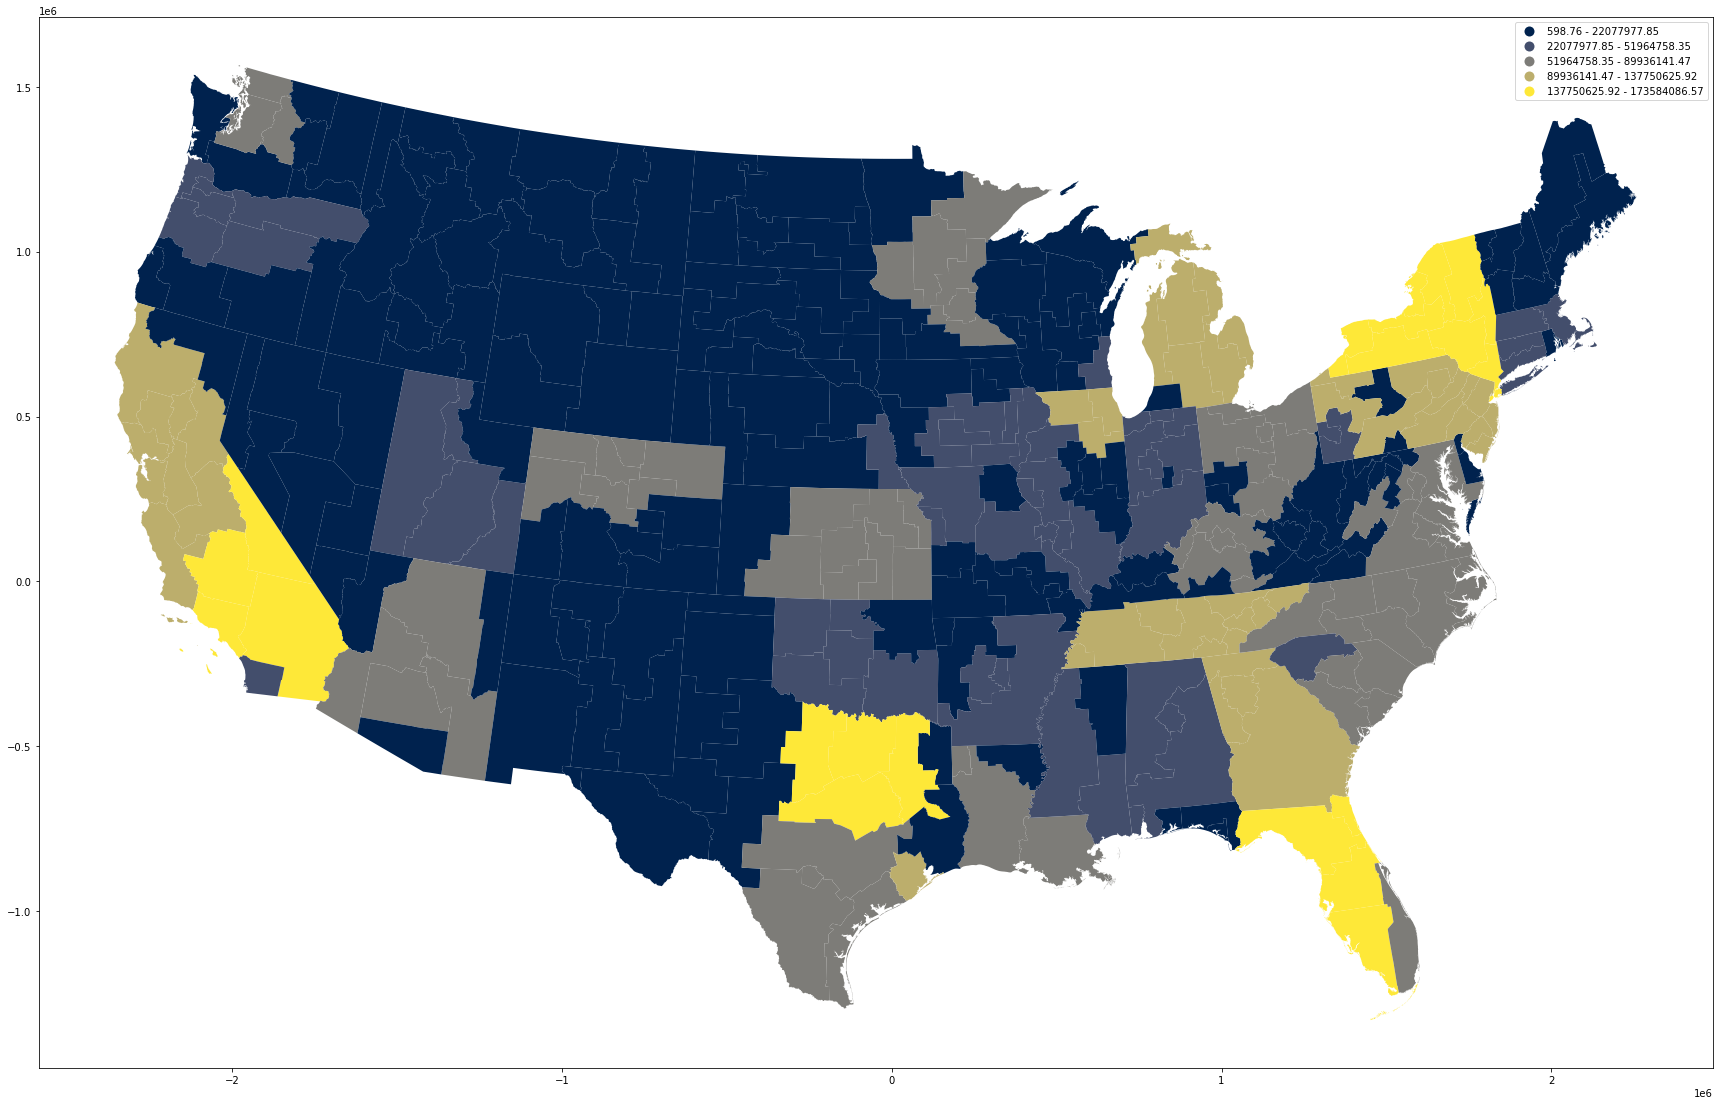

In [126]:
fig, ax = plt.subplots(figsize=(30, 20))
reeds_pca.plot("demand_2018_mwh", ax=ax, legend=True, cmap="cividis", scheme="NaturalBreaks")
plt.show()

## State of Texas

In [144]:
state_demand_factors["Texas"]

0.9802300162327167

In [ ]:
Time Series of individual

In [147]:
gdf[gdf["STATE_FIPS"]==48][["STATE_FIPS", "CNTY_FIPS"]].drop_duplicates()

,STATE_FIPS,CNTY_FIPS
10520,48,141
12018,48,377
12019,48,043
12022,48,243
12023,48,389
...,...,...
22153,48,449
22166,48,387
22168,48,037
22169,48,343
